In [1]:
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parent / "estimation")

if module_path not in sys.path:
    sys.path.append(module_path)

#from synth import generateGrids
#from compression import coilArrayCompression
#from sinc_transforms import pre_comp_sinc_transforms, sinc_rigid_transform

In [2]:
import numpy as np
import twixtools
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.fft as fft

%matplotlib widget
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

C:\Users\giuse\OneDrive\Documents\mri-physics\mri-transform-estimation\env\Lib\site-packages\sigpy\config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
DLL load failed while importing cudnn: The specified module could not be found.
  warnings.warn(


In [3]:
#filename = Path.cwd().parent / "data" / "meas_MID00195_FID07959_T1_Sag_MPRAGE_p2_TR_1870_0_8mm.dat"
#filename = Path("../data/meas_MID00195_FID07959_T1_Sag_MPRAGE_p2_TR_1870_0_8mm.dat")
#print(filename)
filename = r"C:\Users\giuse\Downloads\meas_MID00195_FID07959_T1_Sag_MPRAGE_p2_TR_1870_0_8mm.dat"
#filename =r"C:\Users\giuse\OneDrive\Documents\mri-physics\mri-transform-estimation\data\MR160-088-1298-02_T1_twix\meas_MID00026_FID36518_T1_Sag_MPRAGE_p2_TR_1870_0_8mm.dat"
multi_twix = twixtools.read_twix(filename, parse_pmu=False)

Software version: VD/VE (!?)

Scan  0


100%|██████████████████████████████████████████████████████████████████████████████| 38.1M/38.1M [00:00<00:00, 276MB/s]


Scan  1


100%|██████████████████████████████████████████████████████████████████████████████| 3.72G/3.72G [00:04<00:00, 818MB/s]


In [4]:
def ifftnd(kspace, axes=[-1]):
        if axes is None:
            axes = range(kspace.ndim)
        img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
        img *= np.sqrt(np.prod(np.take(img.shape, axes)))
        return img
    
def rms_comb(sig, axis=1):
        return np.sqrt(np.sum(abs(sig)**2, axis))

In [5]:
# read image data from list of mdbs and sort into 3d k-space (+ coil dim.)
def import_kspace(mdb_list):
    image_mdbs = []
    for mdb in mdb_list:
        if mdb.is_image_scan():
            image_mdbs.append(mdb)

    n_line = 1 + max([mdb.cLin for mdb in image_mdbs])
    n_part = 1 + max([mdb.cPar for mdb in image_mdbs])
    n_channel, n_column = image_mdbs[0].data.shape

    out = np.zeros([n_part, n_line, n_channel, n_column], dtype=np.complex64)
    for mdb in image_mdbs:
        # '+=' takes care of averaging, but careful in case of other counters (e.g. echoes)
        out[mdb.cPar, mdb.cLin] += mdb.data

    return out  # 4D numpy array [n_part, n_line, n_channel, n_column]

In [37]:
# map the twix data to twix_array objects
mapped = twixtools.map_twix(multi_twix)
mapped_img_data = mapped[-1]['image']
mapped_refscan_data = mapped[-1]['refscan']
# make sure that we later squeeze the right dimensions:
print(f'Img Data non singleton dims : {mapped_img_data.non_singleton_dims}')
print(f'RefScan Data non singleton dims : {mapped_refscan_data.non_singleton_dims}')
# the twix_array object makes it easy to remove the 2x oversampling in read direction
mapped_img_data.flags['remove_os'] = True
mapped_img_data.flags['zf_missing_lines'] = True
mapped_refscan_data.flags['remove_os'] = True
mapped_refscan_data.flags['zf_missing_lines'] = True

# read the data (array-slicing is also supported)
image_ksp = mapped_img_data[:].squeeze()
refscan_ksp = mapped_refscan_data[:].squeeze()
print(f'Dimensions of image k-space is {image_ksp.shape}')
print(f'Dimensions of refscan k-space is {refscan_ksp.shape}')

Img Data non singleton dims : ['Par', 'Lin', 'Cha', 'Col']
RefScan Data non singleton dims : ['Par', 'Lin', 'Cha', 'Col']
Dimensions of image k-space is (240, 300, 20, 320)
Dimensions of refscan k-space is (240, 300, 20, 320)


In [38]:
mapped_refscan_data.flags.keys()

dict_keys(['average', 'remove_os', 'regrid', 'apply_fftscale', 'apply_rawdatacorr', 'squeeze_ave_dims', 'squeeze_singletons', 'skip_empty_lead', 'zf_missing_lines', 'user_func'])

In [39]:
image_ksp = np.transpose(image_ksp, (2, 3, 1, 0))
refscan_ksp = np.transpose(refscan_ksp, (2, 3, 1, 0))
print(f'New dimenions are [nc, kx, ky, kz] -> {refscan_ksp.shape}')

New dimenions are [nc, kx, ky, kz] -> (20, 320, 300, 240)


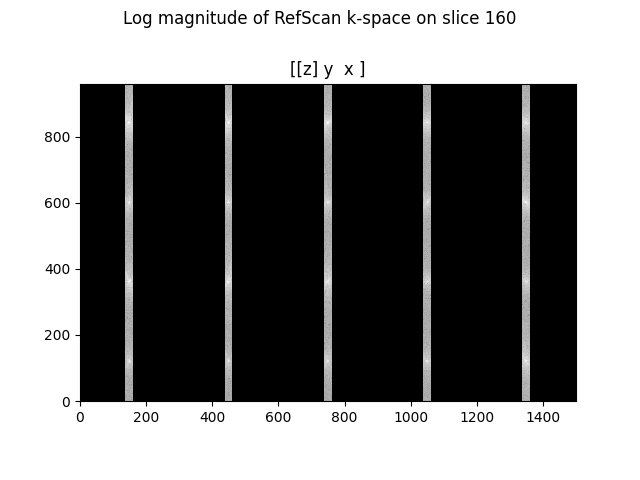

In [9]:
pl.ImagePlot(refscan_ksp[:, 160], z=0, mode='l', title='Log magnitude of RefScan k-space on slice 160')

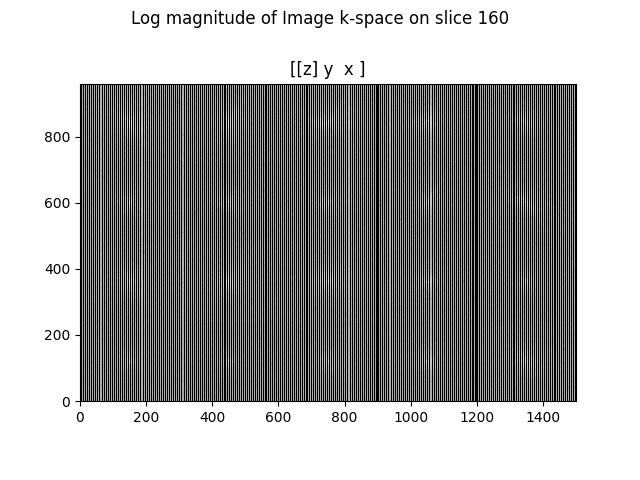

In [10]:
pl.ImagePlot(image_ksp[:, 160], z=0, mode='l', title='Log magnitude of Image k-space on slice 160')

In [40]:
ref_image_volume = sp.ifft(refscan_ksp, axes=(1,2,3))
ref_image_rss = np.sum(np.abs(ref_image_volume)**2, axis=0)**0.5
print(f'Inverse transform shape is {ref_image_volume.shape} squashed on coils becomes {ref_image_rss.shape}')

Inverse transform shape is (20, 320, 300, 240) squashed on coils becomes (320, 300, 240)


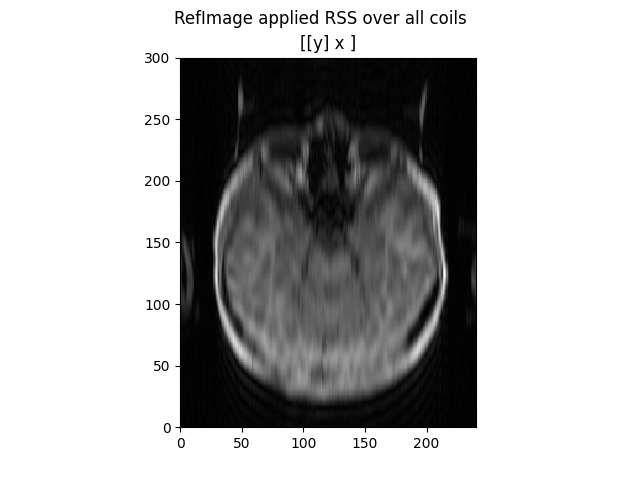

In [42]:
pl.ImagePlot(ref_image_rss[160], mode='m', title='RefImage applied RSS over all coils')

3.304840248574692e-07


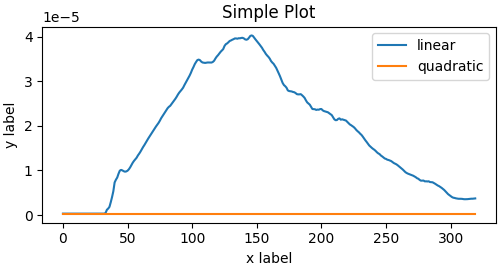

In [45]:
magnitude = np.sum(ref_image_rss**2, axis=(1,2))
percentile = np.percentile(magnitude, 10)
perc = np.full(magnitude.shape, percentile)
print(percentile)
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(magnitude, label='linear')  # Plot some data on the Axes.
ax.plot(perc, label='quadratic')  # Plot more data on the Axes...
 # ... and some more.
ax.set_xlabel('x label')  # Add an x-label to the Axes.
ax.set_ylabel('y label')  # Add a y-label to the Axes.
ax.set_title("Simple Plot")  # Add a title to the Axes.
ax.legend()  # Add a legend.


In [34]:
threshold_idx = np.argwhere(magnitude>percentile).flatten()
for i in threshold_idx:
    print(i)

32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298


In [15]:
refscan_partial_ksp = sp.ifft(refscan_ksp, axes=[1,2,3], norm=None)
print(refscan_partial_ksp.shape)

(20, 320, 240, 300)


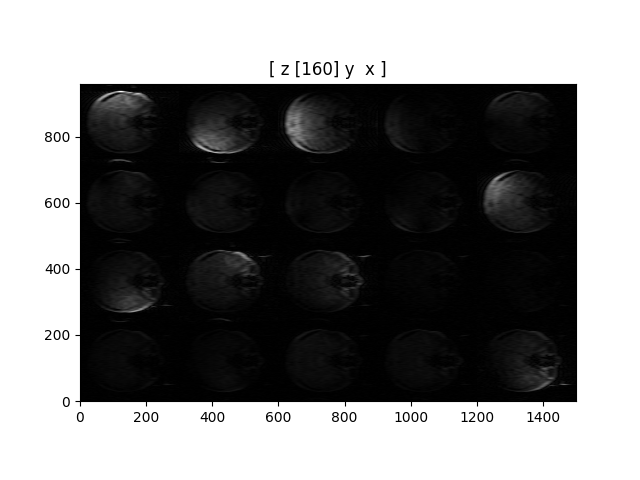

In [16]:
pl.ImagePlot(refscan_partial_ksp, z=0, mode='m')

In [17]:
refscan_partial_ksp_1dim = sp.ifft(refscan_ksp, axes=[1], norm=None)
print(refscan_partial_ksp.shape)

(20, 320, 240, 300)


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

(20, 240, 300)


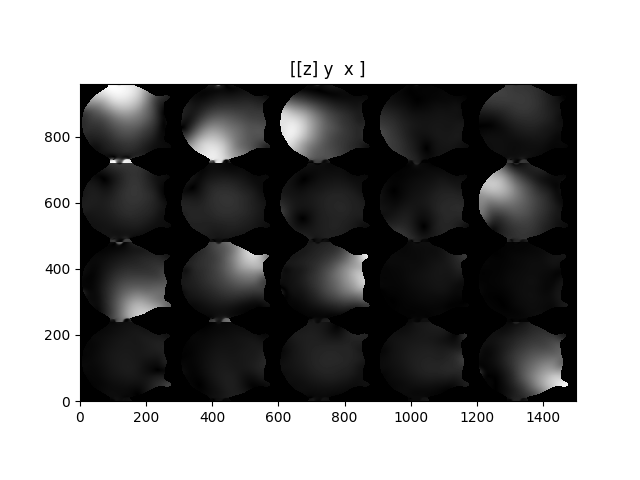

In [18]:
mps = mr.app.EspiritCalib(refscan_partial_ksp_1dim[:,160,...], device=sp.Device(0)).run()
print(mps.shape)
pl.ImagePlot(mps, z=0)

In [19]:
import cupy as cp

In [35]:
result = cp.zeros(refscan_partial_ksp_1dim.shape, dtype=np.complex64)
for i in threshold_idx:
    result[:,i,...] =  mr.app.EspiritCalib(refscan_partial_ksp_1dim[:,i,...], device=sp.Device(0)).run()

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



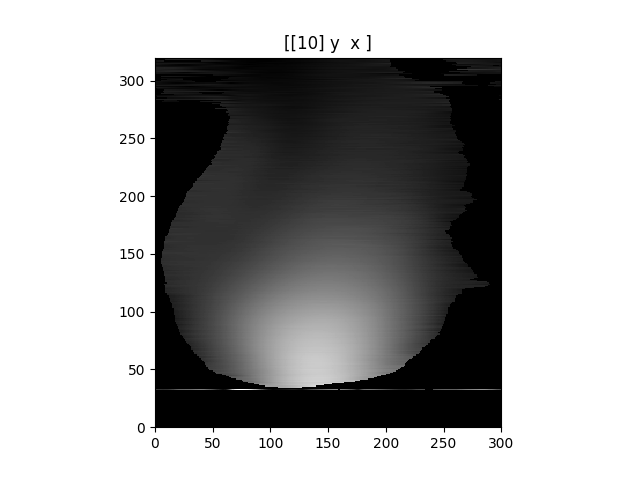

In [36]:
pl.ImagePlot(result[:,:,100, :], mode='m')

In [22]:
pl.ImagePlot(

SyntaxError: incomplete input (525925795.py, line 1)

In [ ]:
image_ksp_partial = sp.ifft(image_ksp, axes=[1], norm=None)
slice_sense = mr.app.SenseRecon(image_ksp_partial[:,160,...], mps, lamda=0.01, device=sp.Device(0)).run()
print(slice_sense.shape)
pl.ImagePlot(slice_sense)

In [ ]:
pl.ImagePlot(slice_sense, mode='p')

In [ ]:
sample_image_volume = sp.ifft(image_ksp, axes=(1,2,3))
sample_image_rss = np.sum(np.abs(sample_image_volume)**2, axis=0)**0.5
pl.ImagePlot(sample_image_rss[160], mode='m')

In [ ]:
channel_mps = mr.app.EspiritCalib(refscan_ksp[10], device=sp.Device(0)).run()
print(channel_mps.shape)
pl.ImagePlot(channel_mps, title='Sense Mappings volume for coil 10')

In [ ]:
image_volume = np.transpose(data, (2, 3, 0, 1))
image_volume.shape

In [ ]:
img_rss = np.sum(np.abs(sp.ifft(image_volume, axes=(-1, -2, -3)))**2, axis=0)**0.5
print(img_rss.shape)
pl.ImagePlot(img_rss, title='Root-sum-of-squares Zero-filled')

In [ ]:
import numpy as np

fft  = lambda x, ax : np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=ax), axes=ax, norm='ortho'), axes=ax) 
ifft = lambda X, ax : np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(X, axes=ax), axes=ax, norm='ortho'), axes=ax) 

def espirit(X, k, r, t, c):
    """
    Derives the ESPIRiT operator.

    Arguments:
      X: Multi channel k-space data. Expected dimensions are (sx, sy, sz, nc), where (sx, sy, sz) are volumetric 
         dimensions and (nc) is the channel dimension.
      k: Parameter that determines the k-space kernel size. If X has dimensions (1, 256, 256, 8), then the kernel 
         will have dimensions (1, k, k, 8)
      r: Parameter that determines the calibration region size. If X has dimensions (1, 256, 256, 8), then the 
         calibration region will have dimensions (1, r, r, 8)
      t: Parameter that determines the rank of the auto-calibration matrix (A). Singular values below t times the
         largest singular value are set to zero.
      c: Crop threshold that determines eigenvalues "=1".
    Returns:
      maps: This is the ESPIRiT operator. It will have dimensions (sx, sy, sz, nc, nc) with (sx, sy, sz, :, idx)
            being the idx'th set of ESPIRiT maps.
    """

    sx = np.shape(X)[0]
    sy = np.shape(X)[1]
    sz = np.shape(X)[2]
    nc = np.shape(X)[3]

    sxt = (sx//2-r//2, sx//2+r//2) if (sx > 1) else (0, 1)
    syt = (sy//2-r//2, sy//2+r//2) if (sy > 1) else (0, 1)
    szt = (sz//2-r//2, sz//2+r//2) if (sz > 1) else (0, 1)

    # Extract calibration region.    
    C = X[sxt[0]:sxt[1], syt[0]:syt[1], szt[0]:szt[1], :].astype(np.complex64)

    # Construct Hankel matrix.
    p = (sx > 1) + (sy > 1) + (sz > 1)
    A = np.zeros([(r-k+1)**p, k**p * nc]).astype(np.complex64)

    idx = 0
    for xdx in range(max(1, C.shape[0] - k + 1)):
      for ydx in range(max(1, C.shape[1] - k + 1)):
        for zdx in range(max(1, C.shape[2] - k + 1)):
          # numpy handles when the indices are too big
          block = C[xdx:xdx+k, ydx:ydx+k, zdx:zdx+k, :].astype(np.complex64) 
          A[idx, :] = block.flatten()
          idx = idx + 1

    # Take the Singular Value Decomposition.
    U, S, VH = np.linalg.svd(A, full_matrices=True)
    V = VH.conj().T

    # Select kernels.
    n = np.sum(S >= t * S[0])
    V = V[:, 0:n]

    kxt = (sx//2-k//2, sx//2+k//2) if (sx > 1) else (0, 1)
    kyt = (sy//2-k//2, sy//2+k//2) if (sy > 1) else (0, 1)
    kzt = (sz//2-k//2, sz//2+k//2) if (sz > 1) else (0, 1)

    # Reshape into k-space kernel, flips it and takes the conjugate
    kernels = np.zeros(np.append(np.shape(X), n)).astype(np.complex64)
    kerdims = [(sx > 1) * k + (sx == 1) * 1, (sy > 1) * k + (sy == 1) * 1, (sz > 1) * k + (sz == 1) * 1, nc]
    for idx in range(n):
        kernels[kxt[0]:kxt[1],kyt[0]:kyt[1],kzt[0]:kzt[1], :, idx] = np.reshape(V[:, idx], kerdims)

    # Take the iucfft
    axes = (0, 1, 2)
    kerimgs = np.zeros(np.append(np.shape(X), n)).astype(np.complex64)
    for idx in range(n):
        for jdx in range(nc):
            ker = kernels[::-1, ::-1, ::-1, jdx, idx].conj()
            kerimgs[:,:,:,jdx,idx] = fft(ker, axes) * np.sqrt(sx * sy * sz)/np.sqrt(k**p)

    # Take the point-wise eigenvalue decomposition and keep eigenvalues greater than c
    maps = np.zeros(np.append(np.shape(X), nc)).astype(np.complex64)
    for idx in range(0, sx):
        for jdx in range(0, sy):
            for kdx in range(0, sz):

                Gq = kerimgs[idx,jdx,kdx,:,:]

                u, s, vh = np.linalg.svd(Gq, full_matrices=True)
                for ldx in range(0, nc):
                    if (s[ldx]**2 > c):
                        maps[idx, jdx, kdx, :, ldx] = u[:, ldx]

    return maps

In [ ]:
image_volume = np.transpose(image_volume,(1,2,3,0))
image_volume.shape

In [ ]:
shifted_volume = sp.ifft(image_volume, axes=(0,))
shifted_volume.shape

In [ ]:
#pl.ImagePlot(image_volume[100,...], z=2, mode='l')
plt.imshow(np.abs(image_volume[100,...,10]), cmap='gray')
plt.show()

In [ ]:
#pl.ImagePlot(shifted_volume[100], x=0, y=1, z=3, title='')
print(shifted_volume.shape)
plt.imshow(np.log(np.abs(image_volume[160, ..., 10])), cmap='gray')
plt.show()

In [ ]:
plt.imshow(np.log(np.abs(temp_slice[0,...,10])), cmap='gray')
plt.show()

In [ ]:
sensies = espirit(image_volume[[100],...], 6, 24, 0.01, 0.95)

In [ ]:
mps = mr.app.EspiritCalib(image_volume, device=gpu_device).run()

In [ ]:
sensies.shape

In [ ]:
pl.ImagePlot(mps, mode='l', z=0, title='Log magnitude of k-space')

In [ ]:
data[100].shape

In [ ]:
lamda = 0.01
img_sense = mr.app.SenseRecon(testing_data, mps, lamda=lamda).run()
img_sense.shape


In [ ]:
pl.ImagePlot(img_sense,mode='m', title='SENSE Reconstruction')

In [ ]:
import scipy
data = scipy.io.loadmat('../data/xGT.mat')
sensitivity = data['S']
ground_truth = data['xGT']

In [ ]:
pl.ImagePlot(ground_truth)

In [ ]:
sensitivity = np.transpose(sensitivity, (3,0,1,2))

In [ ]:
pl.ImagePlot(sensitivity, z=0, x=1, y=2, mode='m')